# AMR Analysis

- References:
  - https://github.com/Sean-Blank/AMRcoref
  - https://github.com/amrisi/amr-guidelines/blob/master/amr.md
  - https://amrlib.readthedocs.io/en/latest/

In [1]:
%load_ext autoreload
%autoreload 2

In [254]:
import os
import pickle
import random
from tqdm.notebook import tqdm
from collections import Counter, defaultdict

import torch
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from datasets import load_dataset, Dataset
import pandas as pd

from sibyl import *

import amrlib
import penman

import seaborn as sns
import matplotlib.pyplot as plt

torch.use_deterministic_algorithms(False)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

### Dataset

In [3]:
dataset = load_dataset("glue", "sst2", split="train")
dataset = dataset.rename_column("sentence", "text")
original_text, original_labels = dataset['text'], dataset['label']

Found cached dataset glue (C:/Users/Fabrice/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


### Boolean Featurizers

In [4]:
stog = amrlib.load_stog_model(device=0, max_sent_len=256)

In [5]:
def contains_duplicates(X):
    seen = set()
    seen_add = seen.add
    for x in X:
        if (x in seen or seen_add(x)):
            return True
    return False

def flatten(l):
    return [item for sublist in l for item in sublist]

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def pickle_list(a_list, a_path):
    with open(a_path, 'wb') as fp:
        pickle.dump(a_list, fp)

def unpickle_list(a_path):
    with open(a_path, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [646]:
class LeGraph:
    def __init__(self, graph):
        self.graph = penman.decode(graph) if not isinstance(graph, penman.graph.Graph) else graph
        self.amr_text = penman.encode(self.graph)

    def contains_concept(self, concepts):
        """
        Concepts are nodes / instances in the AMR graph.
        """
        if not isinstance(concepts, list): concepts = [concepts]
        graph_concepts = [t.target for t in self.graph.instances()]
        return any(c for c in graph_concepts if c in concepts)

    def contains_role(self, roles):
        """
        Roles are edges in the AMR graph.
        """
        if not isinstance(roles, list): roles = [roles]
        print(roles)
        graph_roles = [e.role for e in self.graph.edges()]
        print(graph_roles)
        print(self.graph.edges())
        return any(r for r in graph_roles if r in roles)

    def contains_attribute(self, attributes):
        """
        Attributes are properties of concept nodes, i.e. relationships to 
        constant values.
        """
        if not isinstance(attributes, list): attributes = [attributes]
        graph_attrs = [a.target for a in self.graph.attributes()]
        return any(a for a in graph_attrs if a in attributes)
    
def text2amr(texts):
    if not isinstance(texts, list): texts = [texts]
    gs = stog.parse_sents(texts, add_metadata=False)
    gs = [LeGraph(g) for g in gs]
    return gs

In [125]:
# attributes =============================================================

def contains_imperative(g): return g.contains_attribute("imperative")
def contains_exlamation(g): return g.contains_attribute("expressive")
def contains_negation(g):   return g.contains_attribute("-")

# concepts ===============================================================

def contains_conjunctions(g):         return g.contains_concept(["and", "or", "contrast-01", "either", "neither"])
def contains_interrogative_clause(g): return g.contains_concept("truth-value")
def contains_question(g):             return g.contains_concept(["amr-unknown", "amr-choice"])

# roles ==================================================================

def contains_coreferences(g): return any(r for r in g.amr_text.split() if r in ['i', 'you', 'he', 'she', 'it', 'we', 'they'])
def contains_number(g):       return any(a for a in g.graph.attributes() if a.target.isnumeric())

def contains_accompanier(g):  return g.contains_role(':accompanier')
def contains_age(g):          return g.contains_role(':age')
def contains_beneficiary(g):  return g.contains_role(':beneficiary')
def contains_concession(g):   return g.contains_role(':concession')
def contains_condition(g):    return g.contains_role(':condition')
def contains_consist_of(g):   return any(r for r in g.amr_text.split() if r in [':consist-of'])
def contains_degree(g):       return g.contains_role(':degree')
def contains_destination(g):  return g.contains_role(':destination')
def contains_direction(g):    return g.contains_role(':direction')
def contains_domain(g):       return g.contains_role(':domain')
def contains_duration(g):     return g.contains_role(':duration')
def contains_example(g):      return g.contains_role(':example')
def contains_extent(g):       return g.contains_role(':extent')
def contains_frequency(g):    return g.contains_role(':frequency')
def contains_instrument(g):   return g.contains_role(':instrument')
# def contains_li(g):           return g.contains_role(':li')
def contains_location(g):     return g.contains_role(':location')
def contains_manner(g):       return g.contains_role(':manner')
def contains_medium(g):       return g.contains_role(':medium')
def contains_mod(g):          return g.contains_role(':mod')
def contains_mode(g):         return any(a for a in g.graph.attributes() if ":mode" in a.role)
def contains_name(g):         return g.contains_role(':name')
def contains_ord(g):          return g.contains_role(':ord')
def contains_part(g):         return g.contains_role(':part')
def contains_path(g):         return g.contains_role(':path')
def contains_polarity(g):     return g.contains_role(':polarity')
def contains_polite(g):       return any(r for r in g.amr_text.split() if r in [':polite'])
def contains_poss(g):         return g.contains_role(':poss')
def contains_purpose(g):      return g.contains_role(':purpose')
def contains_quant(g):        return g.contains_role(':quant')
def contains_range(g):        return g.contains_role(':range')
def contains_scale(g):        return g.contains_role(':scale')
def contains_source(g):       return g.contains_role(':source')
def contains_subevent(g):     return g.contains_role(':subevent')
def contains_time(g):         return g.contains_role(':time')
def contains_topic(g):        return g.contains_role(':topic')
def contains_unit(g):         return g.contains_role(':unit')
# def contains_value(g):        return g.contains_role(':value')
def contains_wiki(g):         return g.contains_role(':wiki')

### Convert Text to AMRs

In [10]:
penman_path = "penmans.pkl"
batch_size = 36

In [17]:
if not os.path.exists(penman_path):
    print("computing amrs...")
    amrs = []
    for texts in tqdm(chunker(original_text, batch_size), total=len(original_text)/batch_size):
        amrs.extend(text2amr(texts))
    pickle_list(amrs, penman_path)
else:
    print("loading precomputed amrs...")
    amrs = unpickle_list(penman_path)

loading precomputed amrs...


### Model

In [20]:
pipe = pipeline(task="sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Transforms

In [21]:
blacklist = [Concept2Sentence, ConceptMix, Emojify]
ts = [t(task_name="sentiment", return_metadata=True) for t in TRANSFORMATIONS if t not in blacklist]

### Analysis

In [22]:
from sibyl import acc_at_k
from sklearn.metrics import accuracy_score

In [23]:
def extract_probs(results):
    return np.array([[1-r['score'], r['score']] if r['label'] == "POSITIVE" else [r['score'], 1-r['score']] for r in results])

def compute_accuracy(predictions, labels):
    if len(labels.shape) > 1:
        acc = acc_at_k(labels, predictions, k=2)       
    else:
        acc = accuracy_score(labels, np.argmax(predictions, -1))
    return acc

In [166]:
class AMRBooleanFeature:
    def __init__(self, dataset, amrs, min_samples=5):
        self.dataset = dataset
        self.amrs = amrs     
        self.min_samples = min_samples
    
    def extract_data_containing_feature(self, featurizer, max_size=1000):
        
        self.featurizer = featurizer 
        
        # extract T and F evaluation sets
        ts, fs = [], []
        for g, s, l in zip(self.amrs, self.dataset['text'], self.dataset['label']):
            if self.featurizer(g):
                ts.append((s, l))
                if len(ts) >= max_size:
                    break
            else:
                fs.append((s,l))
        
        len_ts = len(ts)
        len_fs = len(fs)
        
        if len_ts < self.min_samples:
            print(f"Only {len_ts} inputs contain the feature, skipping for insufficient data...")
            self.t_dataset = []
            self.f_dataset = []
            return
        if len_fs < len_ts:
            ts = ts[:len_fs]

        t_texts, t_labels = zip(*ts)
        f_texts, f_labels = zip(*random.sample(fs, len(t_texts)))

        t_texts, t_labels = list(t_texts), one_hot_encode(t_labels, 2)
        f_texts, f_labels = list(f_texts), one_hot_encode(f_labels, 2)

        self.t_dataset = Dataset.from_list(
            [{'text': t, 'label': l} for t, l in zip(t_texts, t_labels)])
        self.f_dataset = Dataset.from_list(
            [{'text': t, 'label': l} for t, l in zip(f_texts, f_labels)])
            
    def generate_transformed_datasets(self, transform):
        
        self.transform = transform
         
        # apply transformation to each set of texts containing the target feature
        transformed_t_text, transformed_t_labels = transform.transform_batch(
            batch=(self.t_dataset['text'], self.t_dataset['label']))
        transformed_f_text, transformed_f_labels = transform.transform_batch(
            batch=(self.f_dataset['text'], self.f_dataset['label']))
        transformed_t_labels = np.stack([np.array(a).squeeze() for a in transformed_t_labels])
        transformed_f_labels = np.stack([np.array(a).squeeze() for a in transformed_f_labels])
        
        self.tran_t_dataset = Dataset.from_list(
            [{'text': t, 'label': l} for t, l in zip(transformed_t_text, transformed_t_labels)])
        self.tran_f_dataset = Dataset.from_list(
            [{'text': t, 'label': l} for t, l in zip(transformed_f_text, transformed_f_labels)]) 
        
        self.t_changed = sum([t1 != t2 for t1, t2 in zip(self.t_dataset, self.tran_t_dataset)]) / len(self.t_dataset['text'])
        self.f_changed = sum([t1 != t2 for t1, t2 in zip(self.f_dataset, self.tran_f_dataset)]) / len(self.f_dataset['text'])
    
    def evaluate_original(self, pipe):
        
        # pass data through the model
        self.orig_t_preds = extract_probs(pipe(KeyDataset(self.t_dataset, "text")))
        self.orig_f_preds = extract_probs(pipe(KeyDataset(self.f_dataset, "text")))
        
        # compute accuracy
        self.orig_t_acc = compute_accuracy(
            self.orig_t_preds, np.argmax(self.t_dataset['label'], -1))
        self.orig_f_acc = compute_accuracy(
            self.orig_f_preds, np.argmax(self.f_dataset['label'], -1))
        
        results = {
            "transform": "original",
            "featurizer": self.featurizer.__name__,
            "num_samples": len(self.t_dataset),
            "T_orig_acc": self.orig_t_acc,
            "F_orig_acc": self.orig_f_acc,
            "T_tran_acc": 0,
            "F_tran_acc": 0,
            "T_changed": 0,
            "F_changed": 0
        }
        
        return results
            
    def evaluate_transform(self, pipe):
               
        # pass data through the model
        self.tran_t_preds = extract_probs(pipe(KeyDataset(self.tran_t_dataset, "text")))
        self.tran_f_preds = extract_probs(pipe(KeyDataset(self.tran_f_dataset, "text")))
        
        # compute accuracy
        self.tran_t_acc = compute_accuracy(
            self.tran_t_preds, np.array(self.tran_t_dataset['label']))
        self.tran_f_acc = compute_accuracy(
            self.tran_f_preds, np.array(self.tran_f_dataset['label']))
        
        results = {
            "transform": self.transform.__class__.__name__,
            "featurizer": self.featurizer.__name__,
            "num_samples": len(self.t_dataset),
            "T_orig_acc": self.orig_t_acc,
            "F_orig_acc": self.orig_f_acc,
            "T_tran_acc": self.tran_t_acc,
            "F_tran_acc": self.tran_f_acc,
            "T_changed": self.t_changed,
            "F_changed": self.f_changed
        }
        
        return results
    
    def get_prediction_details(self):
        # Feature DataFrame: T
        t_df = pd.DataFrame(
            [
                f.t_dataset["text"], 
                f.t_dataset["label"],
                f.orig_t_preds,
                f.tran_t_dataset["text"],
                f.tran_t_dataset["label"],
                f.tran_t_preds,
            ]).T
        t_df.columns = ['orig_t_text', 'orig_t_label', 'orig_t_preds', 
                        'tran_t_text', 'tran_t_label', 'tran_t_preds']
        
        t_df['t_pred_diff'] = t_df.apply(lambda row: np.array(row['orig_t_preds']) - np.array(row['tran_t_preds']), axis=1)

        # Feature DataFrame: F
        f_df = pd.DataFrame(
            [
                f.f_dataset["text"], 
                f.f_dataset["label"],
                f.orig_f_preds,
                f.tran_f_dataset["text"],
                f.tran_f_dataset["label"],
                f.tran_f_preds,
            ]).T
        f_df.columns = ['orig_f_text', 'orig_f_label', 'orig_f_preds', 
                        'tran_f_text', 'tran_f_label', 'tran_f_preds']

        f_df['f_pred_diff'] = f_df.apply(lambda row: np.array(row['orig_f_preds']) - np.array(row['tran_f_preds']), axis=1)
        
        return t_df, f_df

In [167]:
featurizers = [    
    contains_imperative,contains_exlamation,contains_negation,
    contains_conjunctions,contains_interrogative_clause,contains_question,
    contains_coreferences,contains_number,contains_accompanier,
    contains_age,contains_beneficiary,contains_concession,
    contains_condition,contains_consist_of,contains_degree,
    contains_destination,contains_direction,contains_domain,
    contains_duration,contains_example,contains_extent,
    contains_frequency,contains_instrument,contains_location,
    contains_manner,contains_medium,contains_mod,
    contains_mode,contains_name,contains_ord,
    contains_part,contains_path,contains_polarity,
    contains_polite,contains_poss,contains_purpose,
    contains_quant,contains_range,contains_scale,
    contains_source,contains_subevent,contains_time,
    contains_topic,contains_unit,contains_wiki
]

In [168]:
f = AMRBooleanFeature(dataset, amrs)

feature_results = {}
for featurizer in tqdm(featurizers):
    
    # feature info
    feature_name = featurizer.__name__
    print(f"Featurizer: {feature_name}")

    # create feature datasets
    f.extract_data_containing_feature(featurizer, 100)
    if not f.t_dataset:
        continue
    print(f"Dataset Size: {len(f.t_dataset)}")
    print(f"T Feature: {f.t_dataset[0]}")
    print(f"F Feature: {f.f_dataset[0]}")
    
    # evaluation
    results = []
    # evaluate original
    results.append(f.evaluate_original(pipe))
    # evaluate transformations
    for t in ts:
        f.generate_transformed_datasets(t)
        result = f.evaluate_transform(pipe)
        # print(result)
        t_df, f_df = f.get_prediction_details()
        result['t_df'] = t_df
        result['f_df'] = f_df
        results.append(result)
        
    df = pd.DataFrame(results)
    df['T_diff'] = df['T_orig_acc'] - df['T_tran_acc']
    df['F_diff'] = df['F_orig_acc'] - df['F_tran_acc']
    df["diff_impact"] = abs(df['T_diff'] - df['F_diff'])
        
    feature_results[feature_name] = df

  0%|          | 0/45 [00:00<?, ?it/s]

Featurizer: contains_imperative
Dataset Size: 100
T Feature: {'text': 'hide new secretions from the parental units ', 'label': [1.0, 0.0]}
F Feature: {'text': 'randolph ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_exlamation
Dataset Size: 100
T Feature: {'text': 'no lika da ', 'label': [1.0, 0.0]}
F Feature: {'text': "a little too ponderous to work as shallow entertainment , not remotely incisive enough to qualify as drama , monsoon wedding serves mostly to whet one 's appetite for the bollywood films . ", 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_negation
Dataset Size: 100
T Feature: {'text': 'contains no wit , only labored gags ', 'label': [1.0, 0.0]}
F Feature: {'text': 'right stuff ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_conjunctions
Dataset Size: 100
T Feature: {'text': 'contains no wit , only labored gags ', 'label': [1.0, 0.0]}
F Feature: {'text': 'warm water under a red bridge is a celebration of feminine energy , a tribute to the power of women to heal . ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_interrogative_clause
Dataset Size: 78
T Feature: {'text': 'the problem with the film is whether these ambitions , laudable in themselves , justify a theatrical simulation of the death camp of auschwitz ii-birkenau . ', 'label': [1.0, 0.0]}
F Feature: {'text': 'immature and unappealing ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_question
Dataset Size: 100
T Feature: {'text': "... a sour little movie at its core ; an exploration of the emptiness that underlay the relentless gaiety of the 1920 's ... the film 's ending has a `` what was it all for ? '' ", 'label': [1.0, 0.0]}
F Feature: {'text': 'of ` ethnic cleansing ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_coreferences
Dataset Size: 100
T Feature: {'text': "proves once again he has n't lost his touch , bringing off a superb performance in an admittedly middling film . ", 'label': [0.0, 1.0]}
F Feature: {'text': "has always been part of for the most part wilde 's droll whimsy helps `` being earnest '' overcome its weaknesses and parker 's creative interference ... ", 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_number
Dataset Size: 100
T Feature: {'text': "a depressed fifteen-year-old 's suicidal poetry ", 'label': [1.0, 0.0]}
F Feature: {'text': "it 's supposed to be a romantic comedy - it suffers from too much norma rae and not enough pretty woman . ", 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_accompanier
Dataset Size: 100
T Feature: {'text': "build some robots , haul 'em to the theater with you for the late show , and put on your own mystery science theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year ", 'label': [1.0, 0.0]}
F Feature: {'text': 'black hawk down with more heart ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_age
Dataset Size: 100
T Feature: {'text': "a depressed fifteen-year-old 's suicidal poetry ", 'label': [1.0, 0.0]}
F Feature: {'text': 'builds gradually until you feel fully embraced by this gentle comedy . ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_beneficiary
Dataset Size: 100
T Feature: {'text': 'pays earnest homage to turntablists ', 'label': [0.0, 1.0]}
F Feature: {'text': 'an unsophisticated sci-fi drama that takes itself all too seriously . ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_concession
Dataset Size: 100
T Feature: {'text': 'some movies suck you in despite their flaws , ', 'label': [0.0, 1.0]}
F Feature: {'text': 'only open new wounds ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_condition
Dataset Size: 100
T Feature: {'text': 'if anything , see it for karen black , who camps up a storm as a fringe feminist conspiracy theorist named dirty dick . ', 'label': [0.0, 1.0]}
F Feature: {'text': 'virtually nothing to show ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_consist_of
Dataset Size: 100
T Feature: {'text': 'enriched by an imaginatively mixed cast of antic spirits ', 'label': [0.0, 1.0]}
F Feature: {'text': 'the characters , cast in impossibly contrived situations , are totally estranged from reality . ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_degree
Dataset Size: 100
T Feature: {'text': 'that loves its characters and communicates something rather beautiful about human nature ', 'label': [0.0, 1.0]}
F Feature: {'text': ', home movie will leave you wanting more , not to mention leaving you with some laughs and a smile on your face . ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_destination
Dataset Size: 100
T Feature: {'text': 'can open the door to liberation . ', 'label': [0.0, 1.0]}
F Feature: {'text': "the little girls understand , and mccracken knows that 's all that matters . ", 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_direction
Dataset Size: 100
T Feature: {'text': 'fashioning an engrossing entertainment out ', 'label': [0.0, 1.0]}
F Feature: {'text': "the film runs on a little longer than it needs to -- muccino either does n't notice when his story ends or just ca n't tear himself away from the characters -- ", 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_domain
Dataset Size: 100
T Feature: {'text': 'the plot is nothing but boilerplate clichés from start to finish , ', 'label': [1.0, 0.0]}
F Feature: {'text': 'thank ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_duration
Dataset Size: 100
T Feature: {'text': 'remains utterly satisfied to remain the same throughout ', 'label': [1.0, 0.0]}
F Feature: {'text': 'plumbs uncharted depths of stupidity , incoherence and sub-sophomoric sexual banter . ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_example
Dataset Size: 100
T Feature: {'text': 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', 'label': [0.0, 1.0]}
F Feature: {'text': ", it 's because there 's no discernible feeling beneath the chest hair ", 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_extent
Dataset Size: 92
T Feature: {'text': 'wide-awake all the way through ', 'label': [0.0, 1.0]}
F Feature: {'text': "one of the year 's best films ", 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_frequency
Dataset Size: 100
T Feature: {'text': 'will find little of interest in this film , which is often preachy and poorly acted ', 'label': [1.0, 0.0]}
F Feature: {'text': 'luridly graphic and ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_instrument
Dataset Size: 100
T Feature: {'text': "delivers what it promises : a look at the `` wild ride '' that ensues when brash young men set out to conquer the online world with laptops , cell phones and sketchy business plans ", 'label': [0.0, 1.0]}
F Feature: {'text': 'in welcome perspective ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_location
Dataset Size: 100
T Feature: {'text': "the part where nothing 's happening , ", 'label': [1.0, 0.0]}
F Feature: {'text': 'a journey spanning nearly three decades of bittersweet camaraderie and history , in which we feel that we truly know what makes holly and marina tick ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_manner
Dataset Size: 100
T Feature: {'text': 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . ', 'label': [0.0, 1.0]}
F Feature: {'text': '... the efforts of its star , kline , to lend some dignity to a dumb story are for naught . ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_medium
Dataset Size: 100
T Feature: {'text': "build some robots , haul 'em to the theater with you for the late show , and put on your own mystery science theatre 3000 tribute to what is almost certainly going to go down as the worst -- and only -- killer website movie of this or any other year ", 'label': [1.0, 0.0]}
F Feature: {'text': 'prepare ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_mod
Dataset Size: 96
T Feature: {'text': 'contains no wit , only labored gags ', 'label': [1.0, 0.0]}
F Feature: {'text': 'far less sophisticated and ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_mode
Only 0 inputs contain the feature, skipping for insufficient data...
Featurizer: contains_name
Dataset Size: 100
T Feature: {'text': 'on the worst revenge-of-the-nerds clichés the filmmakers could dredge up ', 'label': [1.0, 0.0]}
F Feature: {'text': 'hip hop beat ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_ord
Dataset Size: 100
T Feature: {'text': 'covers this territory with wit and originality , suggesting that with his fourth feature ', 'label': [0.0, 1.0]}
F Feature: {'text': 'more than ably ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_part
Dataset Size: 100
T Feature: {'text': "swimming is above all about a young woman 's face , and by casting an actress whose face projects that woman 's doubts and yearnings , it succeeds . ", 'label': [0.0, 1.0]}
F Feature: {'text': 'heart as important as humor ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_path
Dataset Size: 100
T Feature: {'text': 'he appears miserable throughout as he swaggers through his scenes ', 'label': [1.0, 0.0]}
F Feature: {'text': "it 's funny and human and really pretty damned wonderful , all at once . ", 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_polarity
Dataset Size: 100
T Feature: {'text': 'have i seen a film so willing to champion the fallibility of the human heart ', 'label': [0.0, 1.0]}
F Feature: {'text': 'measured against practically any like-themed film other than its oscar-sweeping franchise predecessor the silence of the lambs , red dragon rates as an exceptional thriller . ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_polite
Only 0 inputs contain the feature, skipping for insufficient data...
Featurizer: contains_poss
Dataset Size: 100
T Feature: {'text': 'that loves its characters and communicates something rather beautiful about human nature ', 'label': [0.0, 1.0]}
F Feature: {'text': 'skip this dreck , ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_purpose
Dataset Size: 100
T Feature: {'text': 'very good viewing alternative ', 'label': [0.0, 1.0]}
F Feature: {'text': "'s no surprise that as a director washington demands and receives excellent performances , ", 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_quant
Dataset Size: 100
T Feature: {'text': 'lend some dignity to a dumb story ', 'label': [1.0, 0.0]}
F Feature: {'text': 'a markedly inactive film ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_range
Dataset Size: 7
T Feature: {'text': "the first bond movie in ages that is n't fake fun ", 'label': [0.0, 1.0]}
F Feature: {'text': 'like the english patient and the unbearable lightness of being ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_scale
Only 1 inputs contain the feature, skipping for insufficient data...
Featurizer: contains_source
Dataset Size: 100
T Feature: {'text': 'hate to tear your eyes away from the images long enough to read the subtitles ', 'label': [0.0, 1.0]}
F Feature: {'text': 'seems timely and important ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_subevent
Dataset Size: 89
T Feature: {'text': 'provide the funniest moments in this oddly sweet comedy about jokester highway patrolmen ', 'label': [0.0, 1.0]}
F Feature: {'text': 'though overall an overwhelmingly positive portrayal ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_time
Dataset Size: 100
T Feature: {'text': "for those moviegoers who complain that ` they do n't make movies like they used to anymore ", 'label': [1.0, 0.0]}
F Feature: {'text': 'things will turn out okay ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_topic
Dataset Size: 100
T Feature: {'text': 'that loves its characters and communicates something rather beautiful about human nature ', 'label': [0.0, 1.0]}
F Feature: {'text': 'human nature is a goofball movie , in the way that malkovich was , but it tries too hard ', 'label': [1.0, 0.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_unit
Dataset Size: 100
T Feature: {'text': "a depressed fifteen-year-old 's suicidal poetry ", 'label': [1.0, 0.0]}
F Feature: {'text': 'an admittedly middling film ', 'label': [0.0, 1.0]}


C:\Users\Fabrice\anaconda3\envs\dpml\lib\site-packages\transformers\pipelines\base.py:1043: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Featurizer: contains_wiki
Only 0 inputs contain the feature, skipping for insufficient data...


In [198]:
# save results dict as pickle file
pickle_out = open('analysis_results.pkl', 'wb')
pickle.dump(feature_results, pickle_out)
pickle_out.close()

In [ ]:
# create new dictionary from pickle file
pickle_in = open('analysis_results.pkl', 'rb')
new_dict = pickle.load(pickle_in)

## Results Viewer

In [887]:
class ResultsViewer:
    
    def __init__(self, results, disparate_impact_threshold=0.1):
        self.results = results
        self.features = list(self.results.keys())
        self.transforms = self.results[self.features[0]]['transform'].to_list()
        self.disparate_impact_threshold = disparate_impact_threshold
        
        self.disparate_impact_transforms = list(self.find_all_features_with_disparate_impact().keys())
        
        out = self.find_all_transforms_with_disparate_impact()
        new_out = {}
        for k, v in out.items():
            if v:
                new_out[k] = v
        self.disparate_impact_features = list(new_out.keys())
        
        self.display_cols = ['transform', 'featurizer', 'num_samples', 'T_changed', 'F_changed',
                             'T_diff', 'F_diff', 'diff_impact']
        
        self.df = pd.concat(df for f, df in self.results.items())
        self.df['diff'] = rv.df['T_diff'] - rv.df['F_diff']
        
    def find_transforms_with_disparate_impact(self, df):
        return df[df["diff_impact"] > self.disparate_impact_threshold]['transform'].to_list()
    
    def find_all_transforms_with_disparate_impact(self):
        out = {}
        for featurizer, df in self.results.items():
            out[featurizer] = self.find_transforms_with_disparate_impact(df)
        return out
    
    def find_all_features_with_disparate_impact(self):
        out = self.find_all_transforms_with_disparate_impact()
        new_dict = defaultdict(list)
        for featurizer, problem_trans in out.items():
            for trans in problem_trans:
                new_dict[trans].append(featurizer) 
        return new_dict
    
    def plot_disparate_impact(self, df):
        g = sns.barplot(data=df, x="transform", y="diff_impact")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set(title=df["featurizer"][0])
        plt.show()
        
    def plot_all_disparate_impact(self):
        for featurizer, df in self.results.items():
            g = sns.barplot(data=df, x="transform", y="diff_impact")
            g.set_xticklabels(g.get_xticklabels(), rotation=90)
            g.set(title=df["featurizer"][0])
            plt.show()
            
    def find_disparate_impact_features(self, threshold=0.0):
        out = self.find_all_features_with_disparate_impact()
        df = pd.DataFrame(Counter(flatten(out.values())), index=[0]).T.reset_index()
        df.columns = ["feature", "count"]
        df["percent"] = df["count"] / len(self.transforms)
        return df[df["percent"] >= threshold]
            
    def find_disparate_impact_transforms(self, threshold=0.0):
        out = self.find_all_transforms_with_disparate_impact()
        df = pd.DataFrame(Counter(flatten(out.values())), index=[0]).T.reset_index()
        df.columns = ["transform", "count"]
        df["percent"] = df["count"] / len(self.features)
        return df[df["percent"] >= threshold]
    
    def plot_disparate_impact_features(self):
        df = self.find_disparate_impact_features()
        g = sns.barplot(data=df, x="feature", y="percent")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set(title="Frequency of Disparate Impact")
        plt.show()
         
    def plot_disparate_impact_transforms(self):
        df = self.find_disparate_impact_transforms()
        g = sns.barplot(data=df, x="transform", y="percent")
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        g.set(title="Frequency of Disparate Impact")
        plt.show()
        
    def display_record_details(self, details):
        orig_text = details["orig_t_text"] if "orig_t_text" in details else details["orig_f_text"]
        tran_text = details["tran_t_text"] if "tran_t_text" in details else details["tran_f_text"]
        show_diffs(orig_text, tran_text, details)
        
    def find_examples_with_different_pred_logits(self, df, num=1, threshold=0.1, display_html=True):
        df = df[df["t_pred_diff"].apply(lambda x: abs(x[0]))  > threshold]
        if not df.empty:
            df = df.sample(num)
        if display_html:
            for i, row in df.iterrows():
                details = row.to_dict()
                self.display_record_details(details)
        return df

    def find_examples_with_different_pred_class(self, df, num=1, display_html=True):
        is_T = "orig_t_text" in df.columns
        df["orig_pred_class"] = df["orig_t_preds" if is_T else "orig_f_preds"].apply(lambda x: np.argmax(x))
        df["tran_pred_class"] = df["tran_t_preds" if is_T else "tran_f_preds"].apply(lambda x: np.argmax(x))
        df = df[~(df['orig_pred_class'] == df['tran_pred_class'])]
        if not df.empty:
            df = df.sample(num)
        if display_html:
            for i, row in df.iterrows():
                details = row.to_dict()
                self.display_record_details(details)
        return df
    
    def get_examples_by_feature_transform(self, feature, transform, num=1):
        df = self.results[feature]
        t_df = df[df["transform"] == transform]["t_df"].iloc[0]
        f_df = df[df["transform"] == transform]["f_df"].iloc[0]
        
        print(f"Text {feature}: True")
        _ = self.find_examples_with_different_pred_class(t_df, num=num, display_html=True)
        print(f"Text {feature}: False")
        _ = self.find_examples_with_different_pred_class(f_df, num=num, display_html=True)
        
    def get_feature_details(self, feature, sort=True, filter_cols=True):
        df = self.results[feature]
        if filter_cols:
            df = df[self.display_cols]
        if sort: 
            return df.sort_values("diff_impact", ascending=False)
        return df
    
    def get_disparate_impact_details(self, feature, sort=True, filter_cols=True):
        df = self.get_feature_details(feature, sort, filter_cols)
        return df[df["diff_impact"] > self.disparate_impact_threshold]
    
    def plot_mean_acc_diff_for_all_transforms(self):
        df = self.df
        
        df_t = df[(df["transform"] != "original") & (df["T_diff"] > 0)]
        df_t = df_t.groupby("transform").mean().reset_index()
        g = sns.barplot(data=df_t, 
                        x="T_diff", 
                        y="transform", 
                        color="b", 
                        label="contains_feature:True",
                        alpha=0.6)

        df_f = df[(df["transform"] != "original") & (df["F_diff"] > 0)]
        df_f = df_f.groupby("transform").mean().reset_index()
        g = sns.barplot(data=df_f, 
                        x="F_diff", 
                        y="transform", 
                        color="r", 
                        label="contains_feature:False",
                        alpha=0.6)

        g.legend(loc="lower right", frameon=True)
        g.set(title="Average $\Delta$ in Model Accuracy for All AMR Features", 
              xlabel='$\Delta$ Model Accuracy', 
              ylabel='Transform')
        plt.show()
        
    def plot_mean_acc_diff_for_all_features(self):
        df = self.df
        
        df_t = df[(df["transform"] != "original") & (df["T_diff"] > 0)]
        df_t = df_t.groupby("featurizer").mean().reset_index()
        g = sns.barplot(data=df_t, 
                        x="T_diff", 
                        y="featurizer", 
                        color="b", 
                        label="contains_feature:True",
                        alpha=0.6)

        df_f = df[(df["transform"] != "original") & (df["F_diff"] > 0)]
        df_f = df_f.groupby("featurizer").mean().reset_index()
        g = sns.barplot(data=df_f, 
                        x="F_diff", 
                        y="featurizer", 
                        color="r", 
                        label="contains_feature:False",
                        alpha=0.6)

        g.legend(loc="lower right", frameon=True)
        g.set(title="Average $\Delta$ in Model Accuracy for All Transforms", 
              xlabel='$\Delta$ Model Accuracy', 
              ylabel='Feature',
              yticklabels=[t.get_text().replace("contains_", "") for t in g.get_yticklabels()])
        plt.show()
        
    def get_disparate_impact_heatmap(self):
        cols = ['transform', 'featurizer', 'diff']
        df_heat = self.df[cols].pivot_table(values='diff', 
                                            index='transform', 
                                            columns='featurizer', 
                                            aggfunc='mean')
        g = sns.heatmap(df_heat, cmap="coolwarm")
        g.set(title="Disparate Impact: $\Delta$ in Model Accuracy Based on Feature Presence / Absence", 
              xlabel='Feature', 
              ylabel='Transform',
              xticklabels=[t.get_text().replace("contains_", "") for t in g.get_xticklabels()])
        plt.show()

#### Observations

Note: Significant differences are any greater than 10%

1. Transforms
    - 22 out of 36 transforms had disparate impacts based on the presence of different AMR features.
    - 6 transforms showed disparate impacts for >= 20% of features (run: rv.find_disparate_impact_transforms(0.2))
        - AddNegation (20%)
        - InsertPositivePhrase (34%)
        - AddNegativeLink (34%)
        - HomoglyphSwap (34%)
        - RandomCharSwap (27%)
        - ChangeAntonym (22%)
    - 2 features showed disparate impacts for >= 20% of transforms (run: rv.find_disparate_impact_features(0.2))
        - contains_interrogative_clause (24%)
        - contains_range (41%) [NOTE: Only 7 examples of ranges in all of SST2]

In [888]:
rv = ResultsViewer(feature_results)

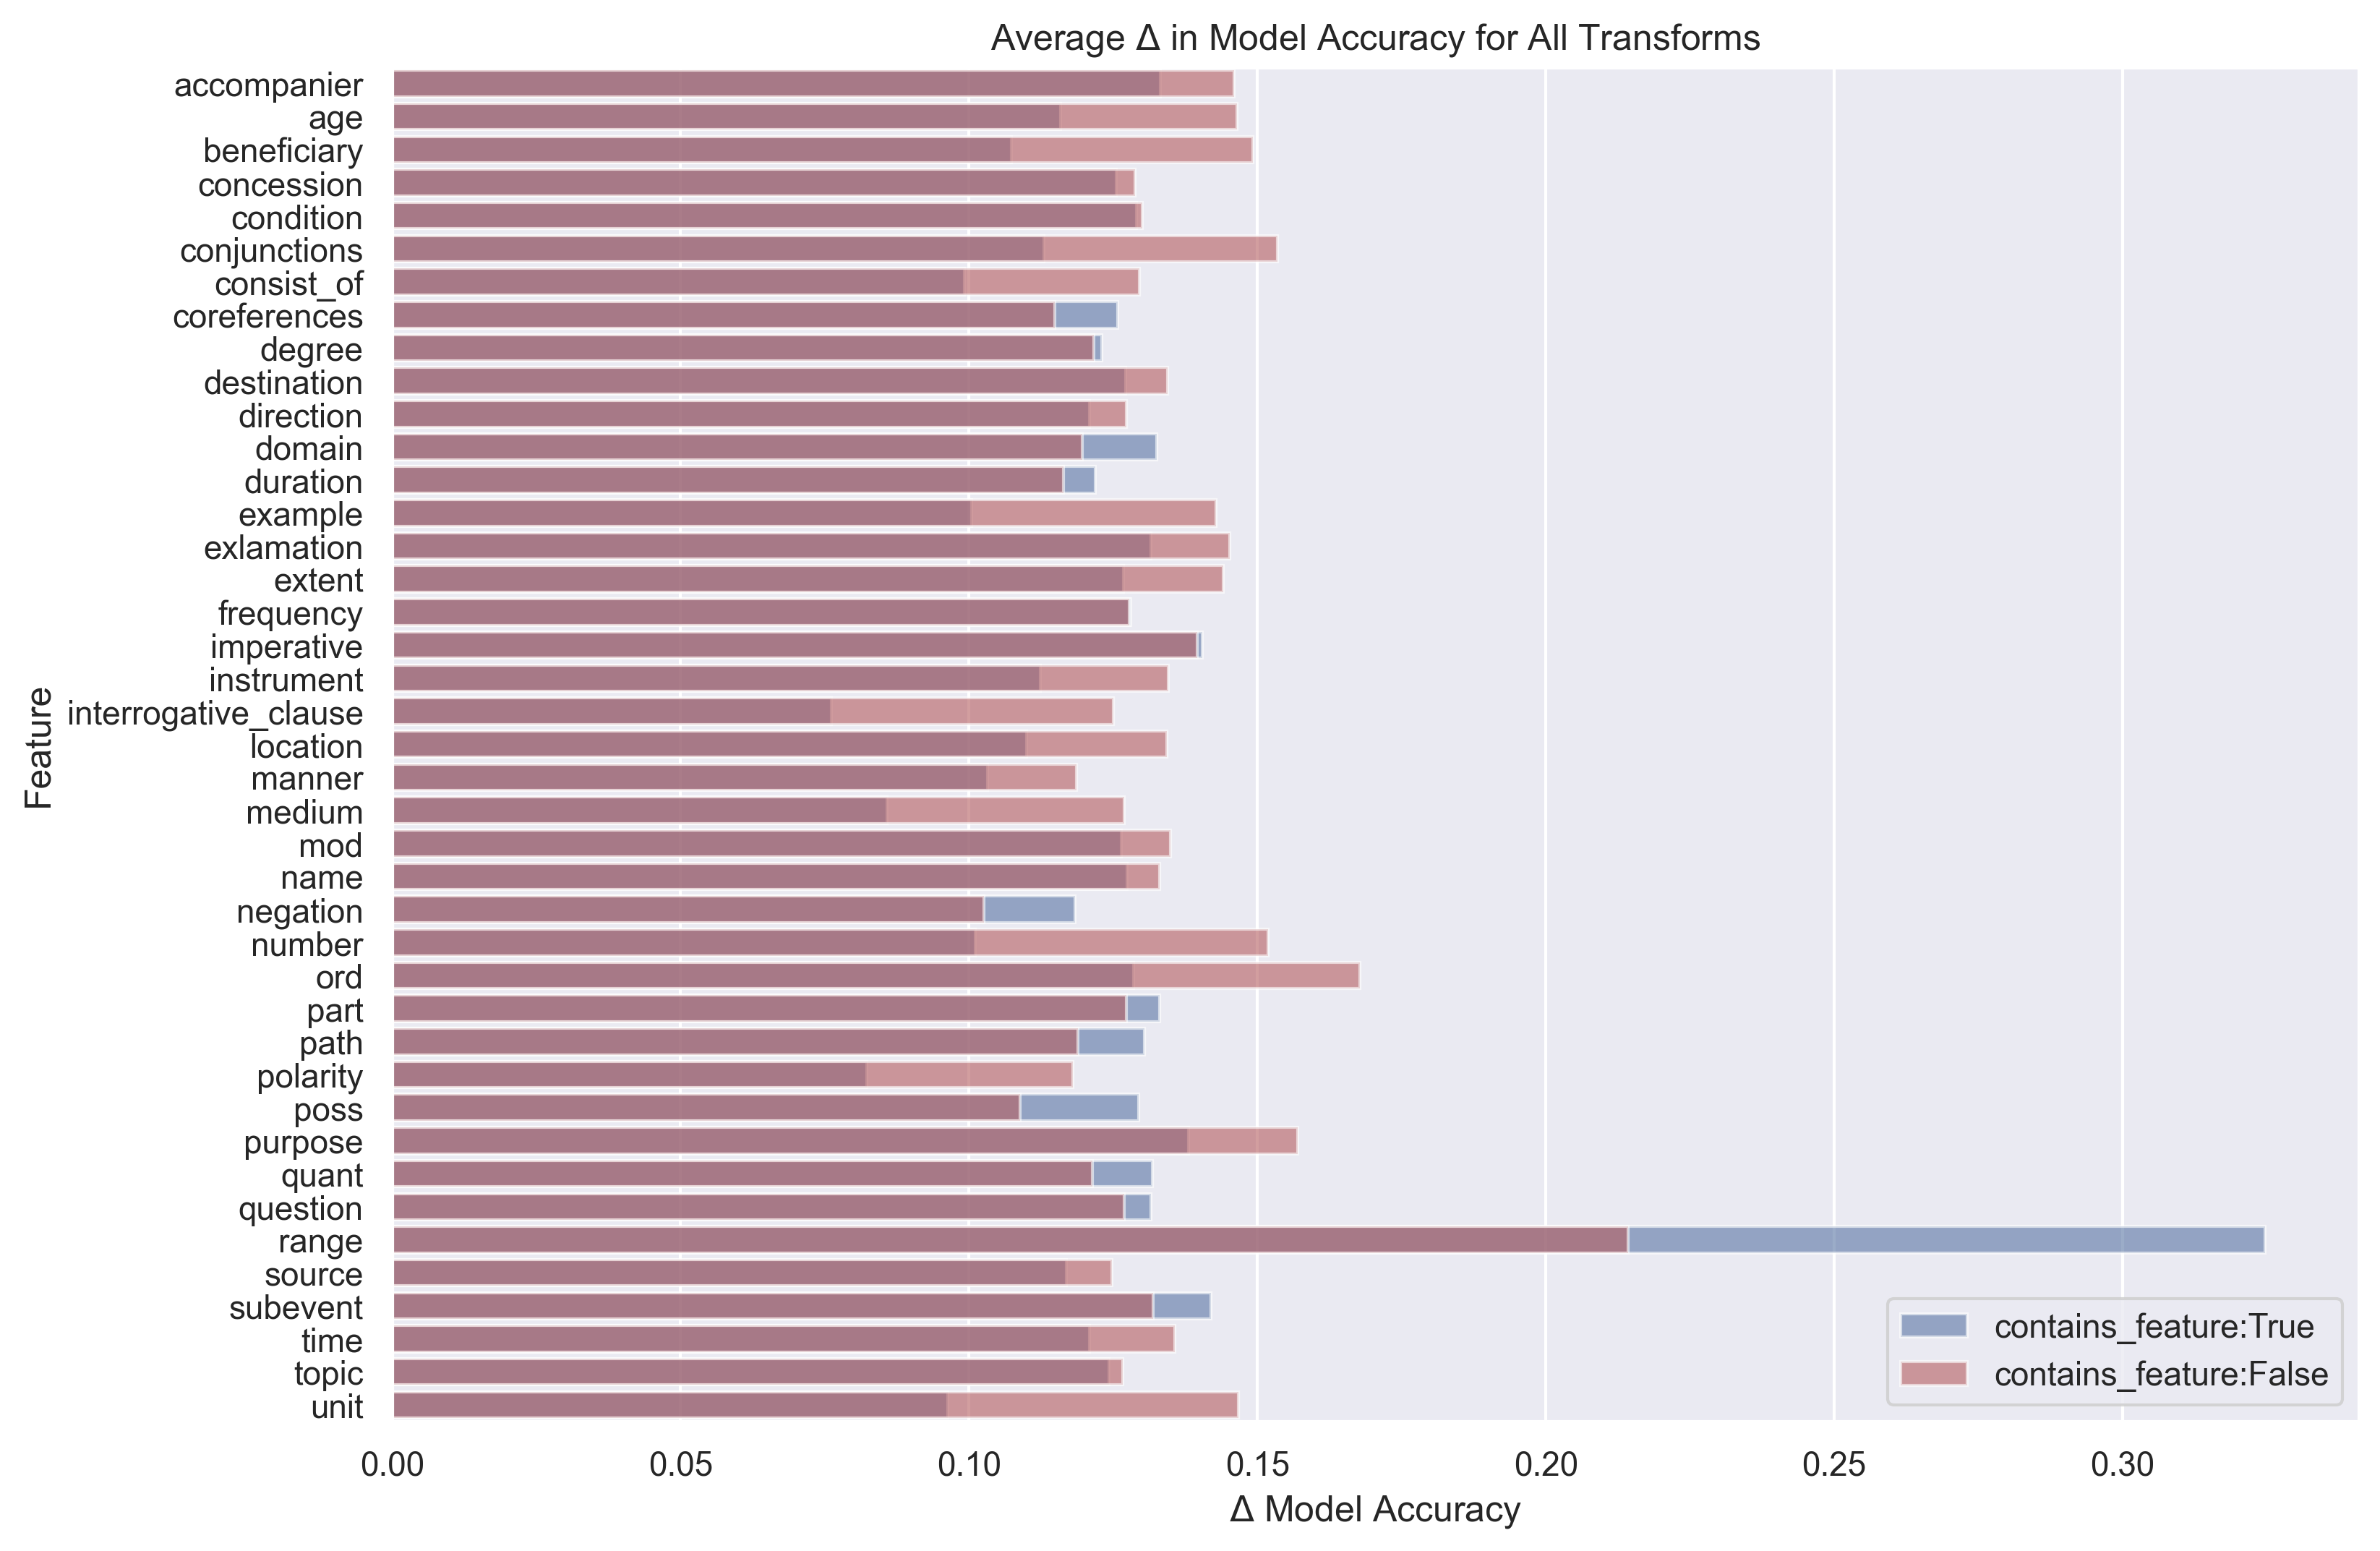

In [889]:
rv.plot_mean_acc_diff_for_all_features()

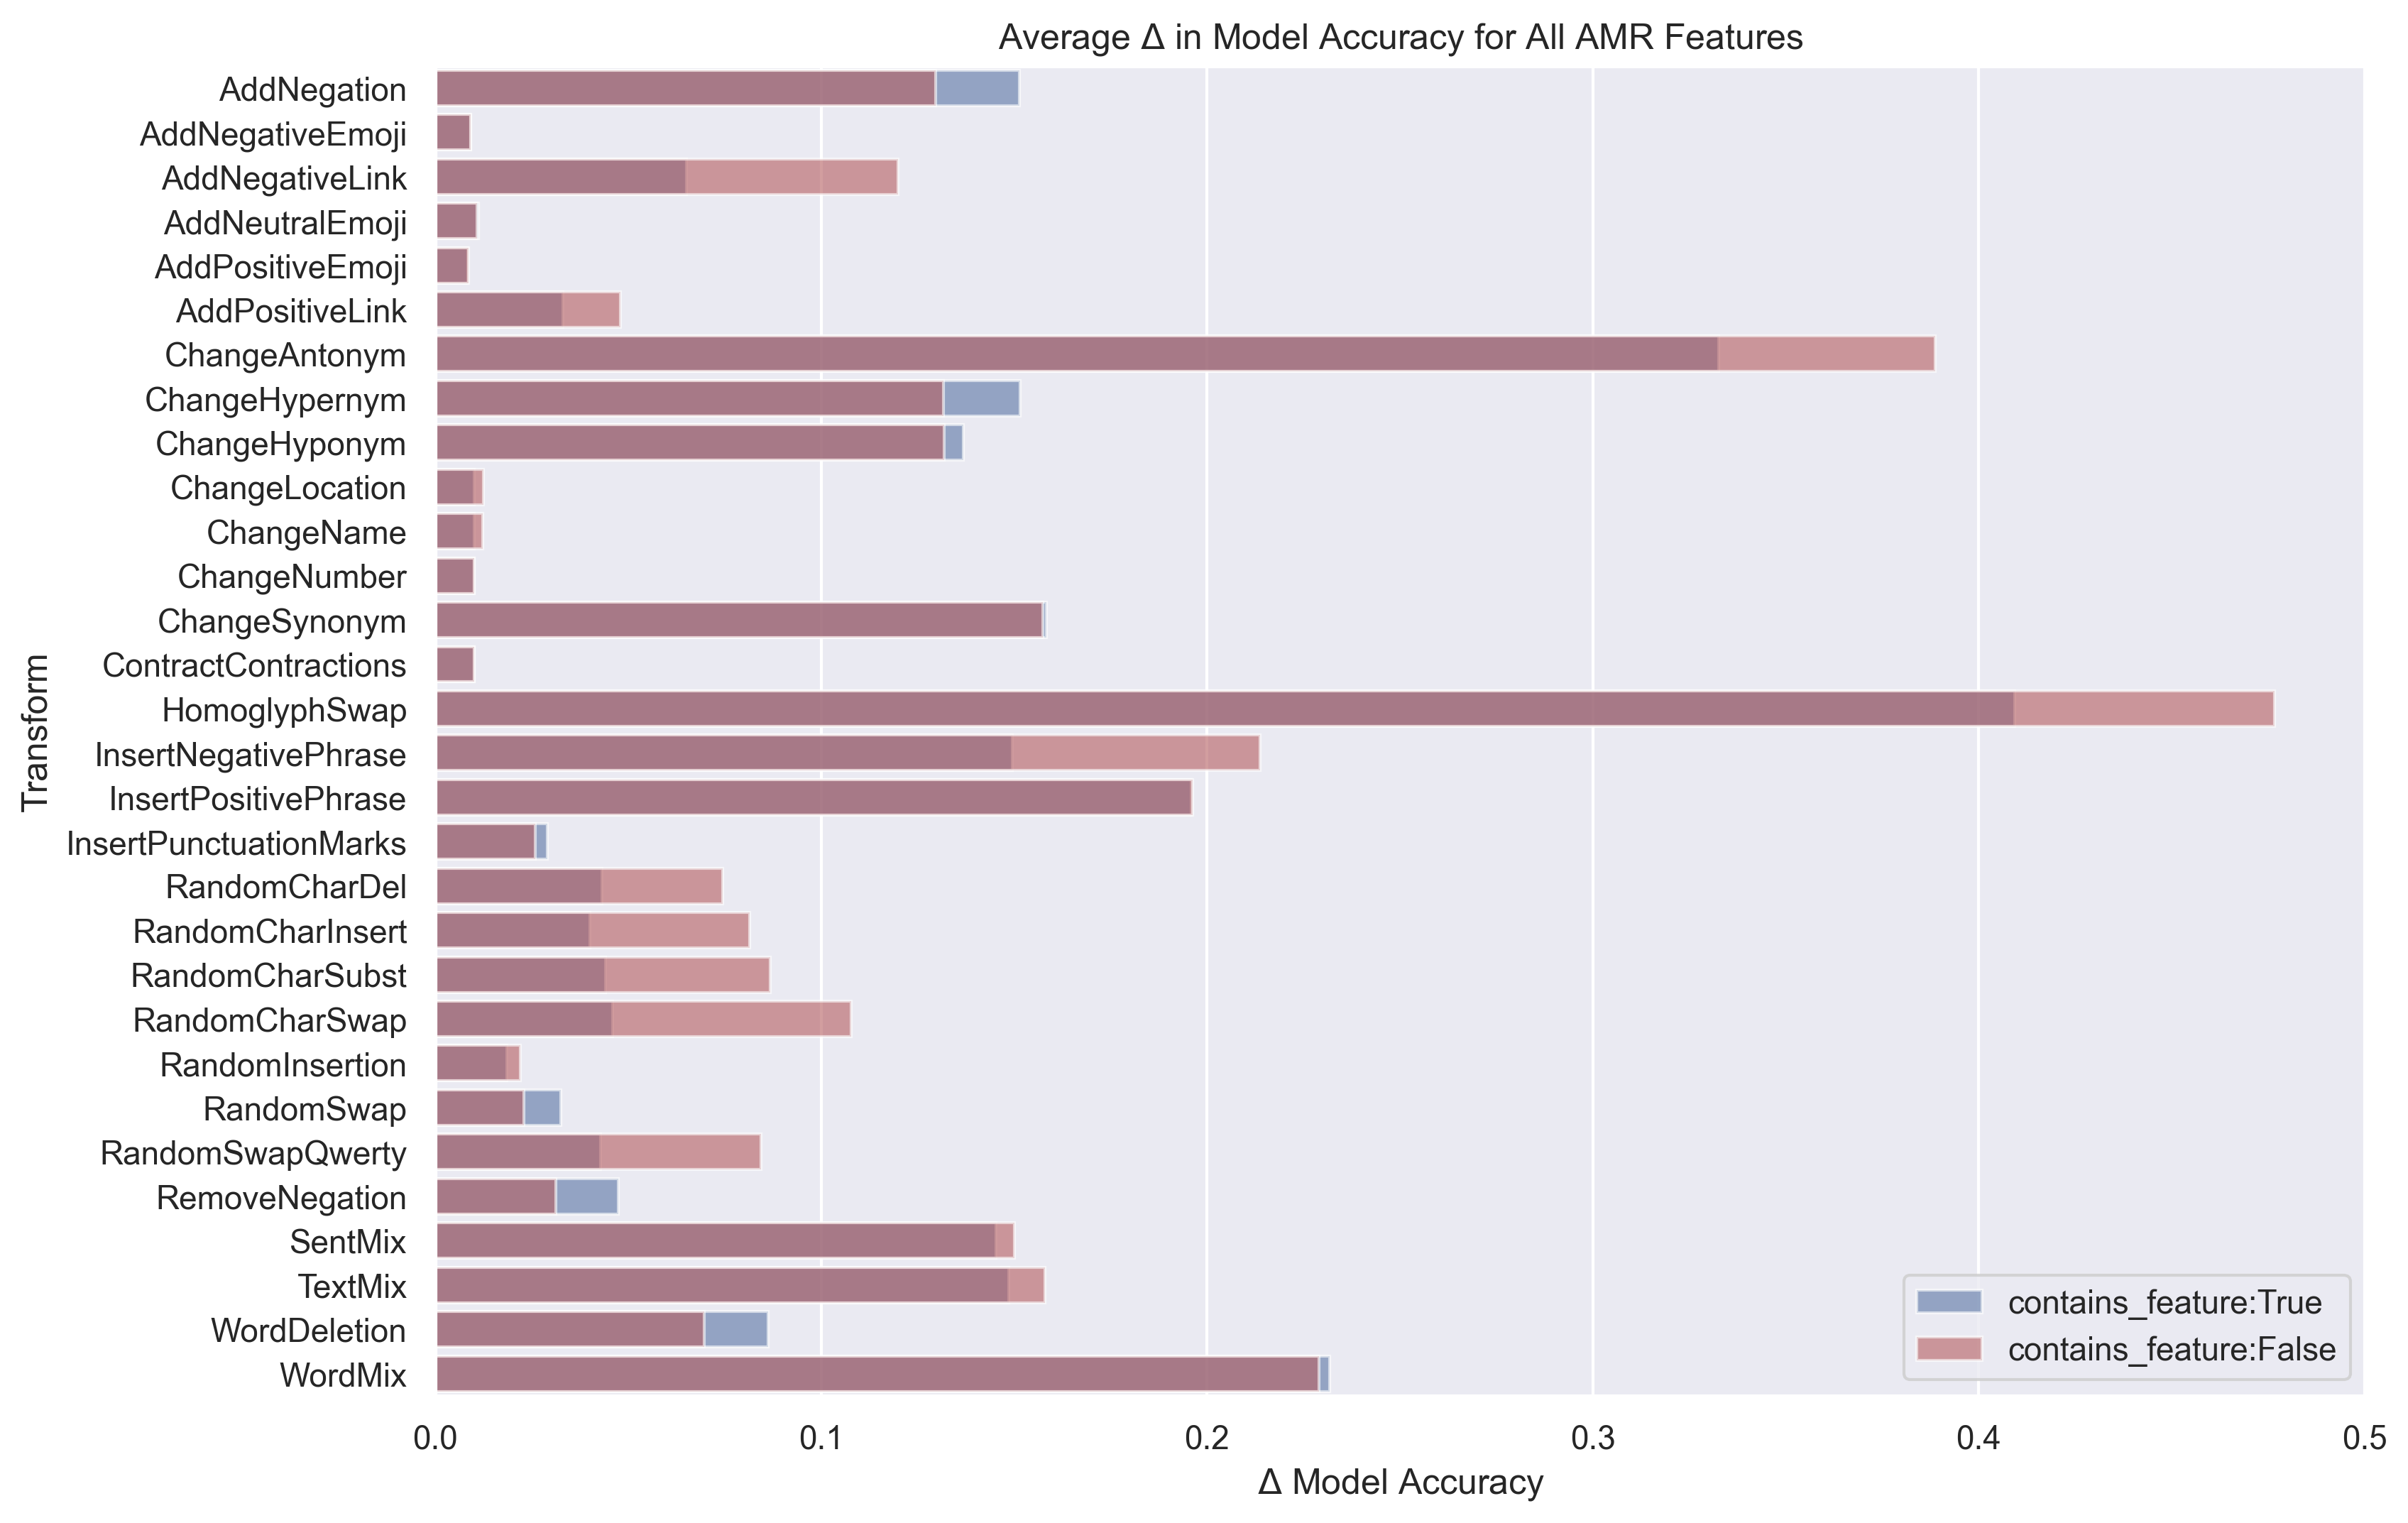

In [890]:
rv.plot_mean_acc_diff_for_all_transforms()

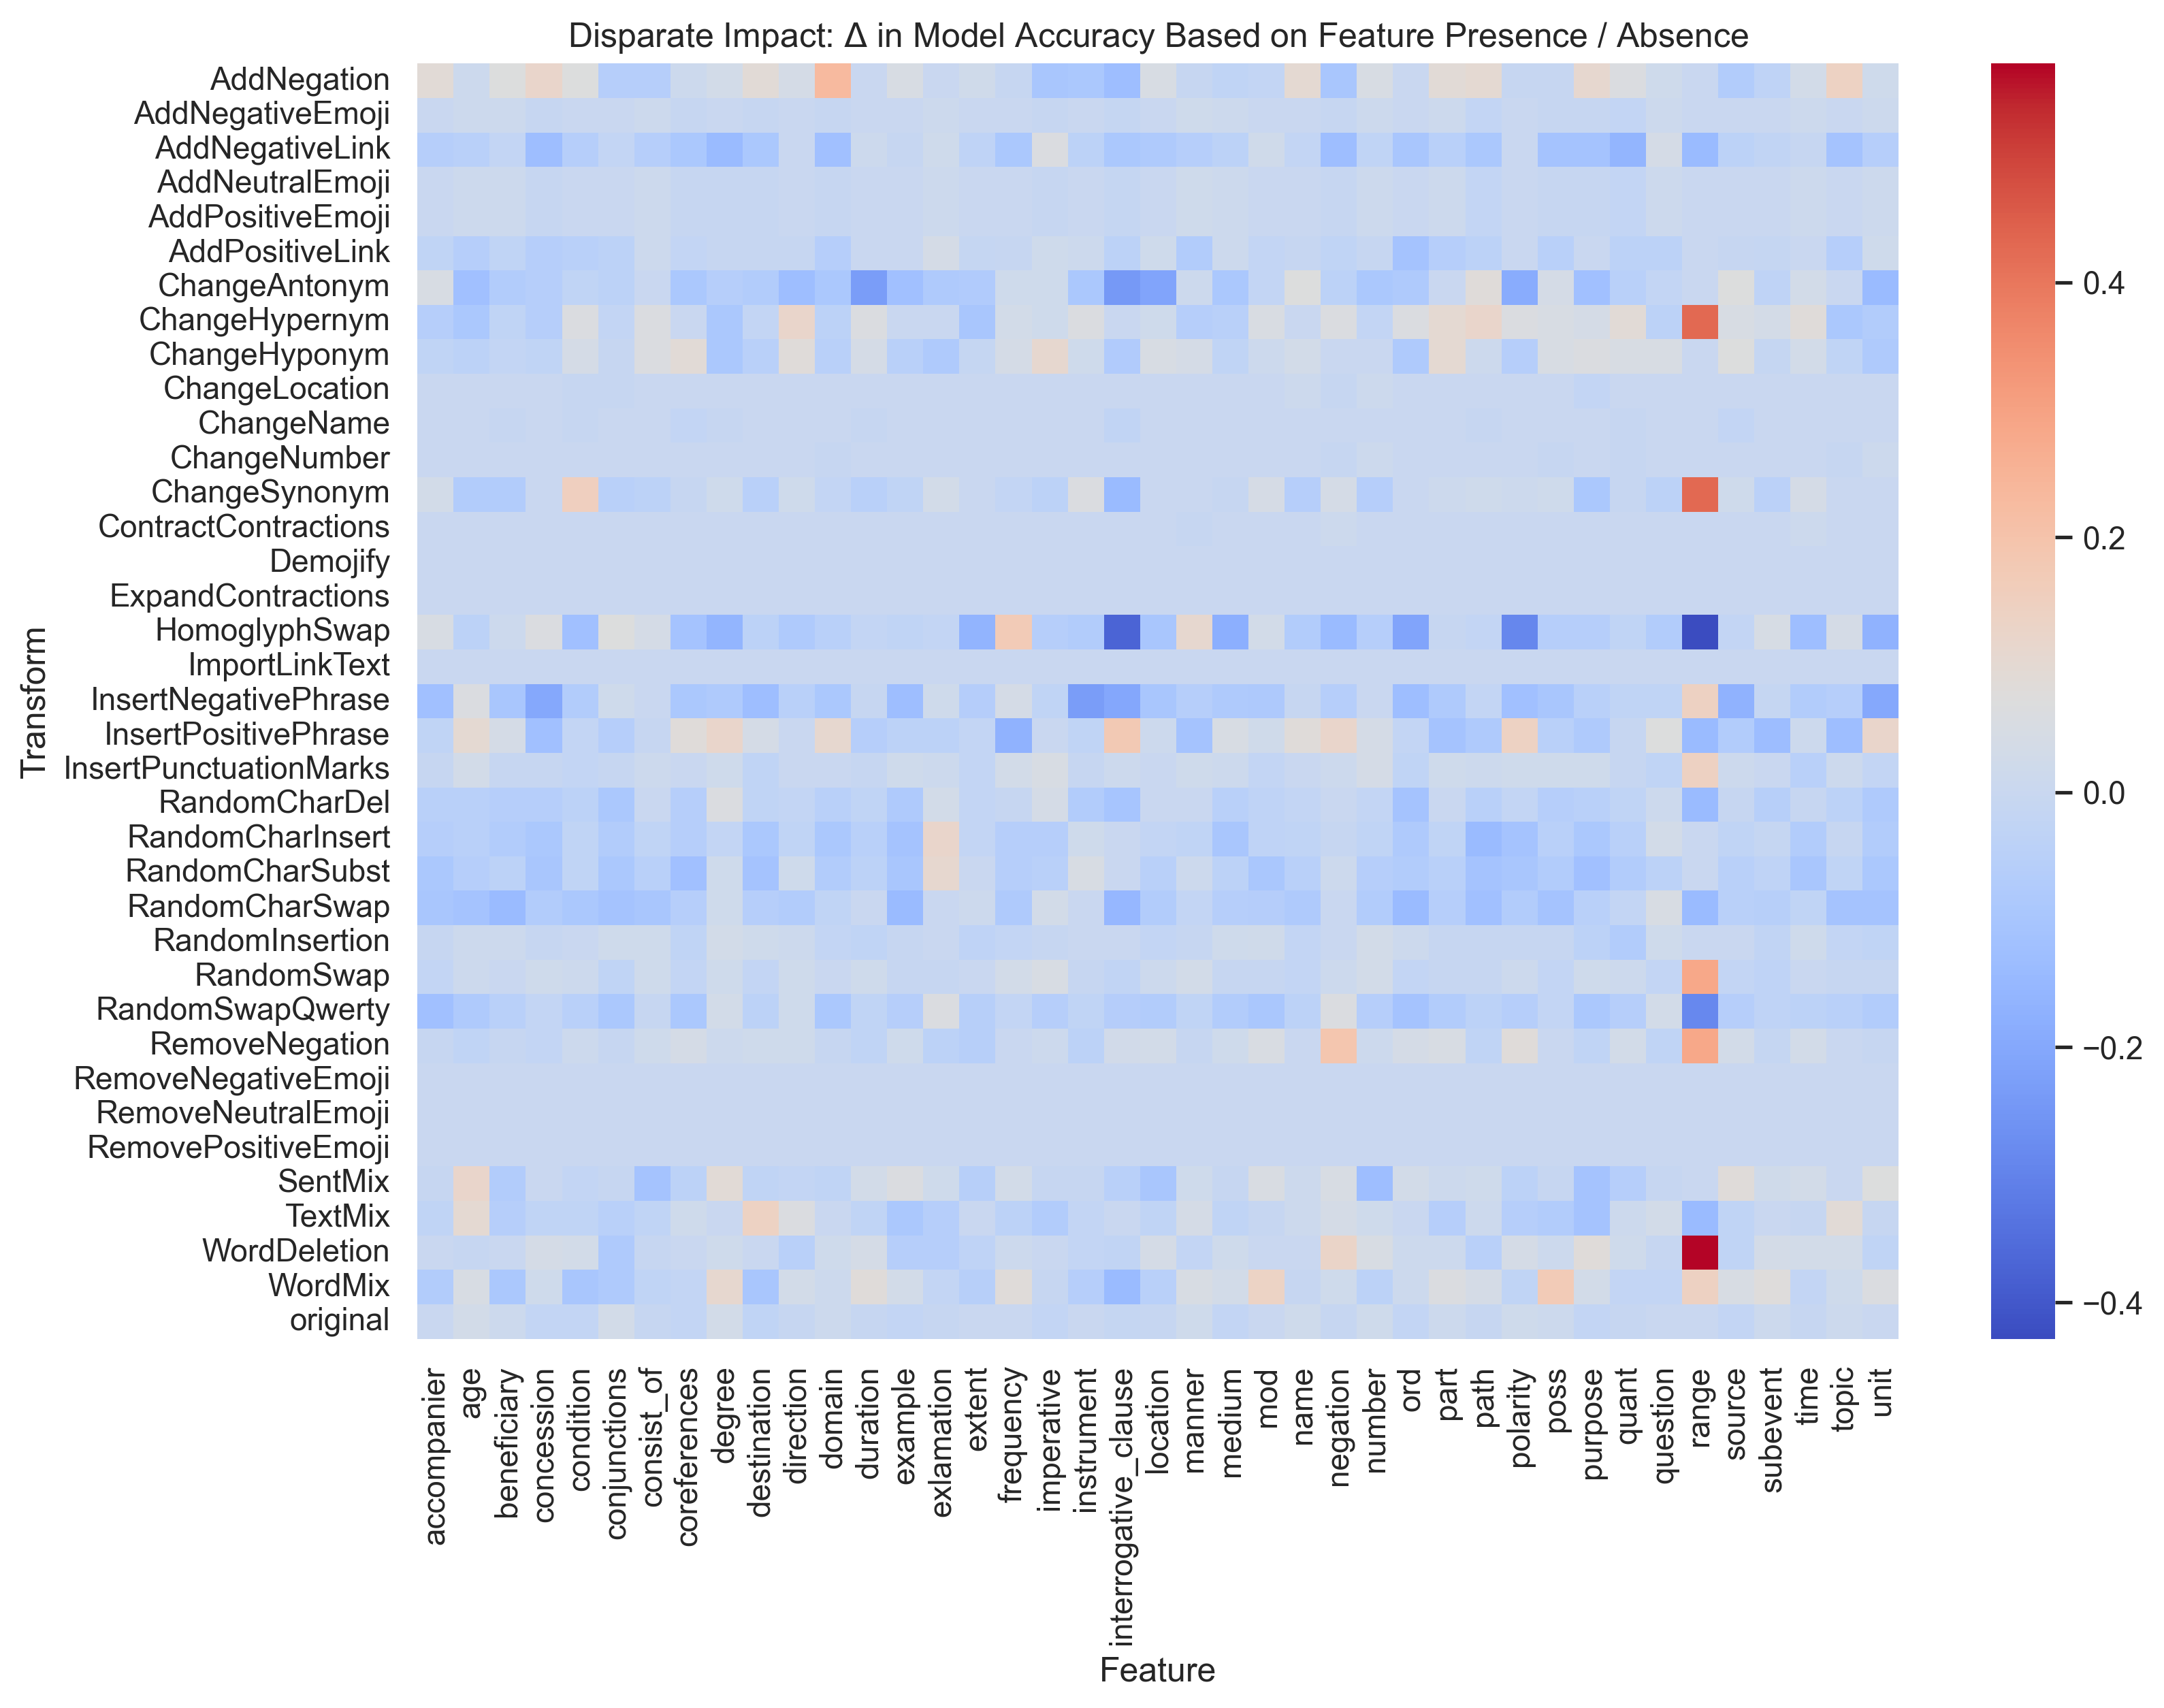

In [891]:
rv.get_disparate_impact_heatmap()

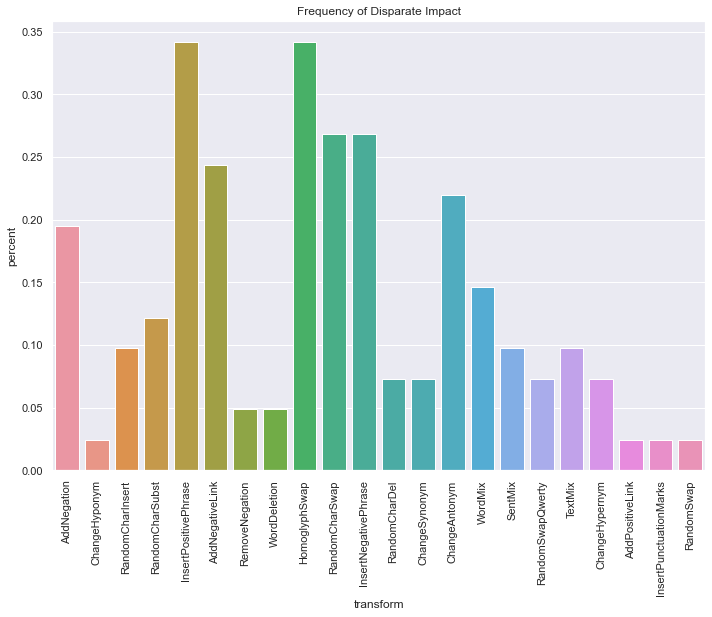

In [827]:
# build graph x = transform, y = absolute change in model accuracy
rv.plot_disparate_impact_transforms()

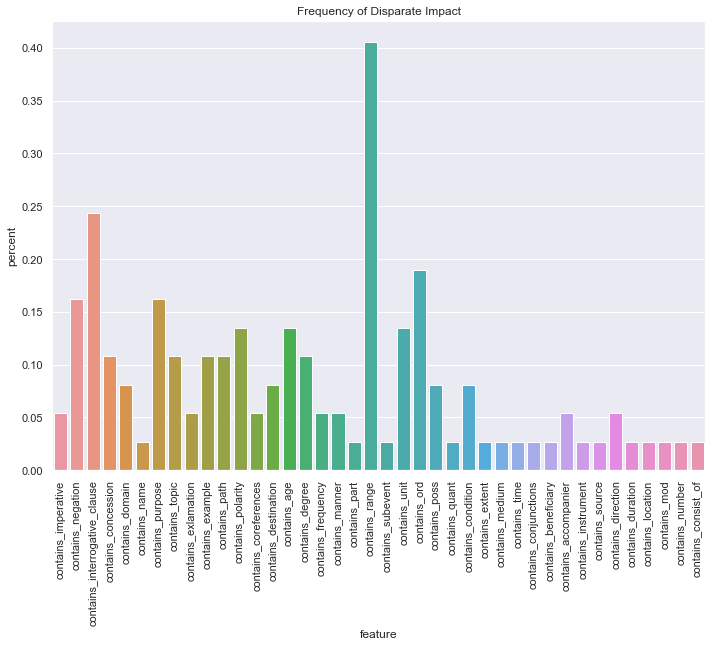

In [828]:
rv.plot_disparate_impact_features()

In [ ]:
# put together heatmap to display all these details

In [876]:
rv.df[rv.df["featurizer"] == "contains_interrogative_clause"]

,transform,featurizer,num_samples,T_orig_acc,F_orig_acc,T_tran_acc,F_tran_acc,T_changed,F_changed,t_df,f_df,T_diff,F_diff,diff_impact,diff
0,original,contains_interrogative_clause,78,0.99,1.00,0.00,0.00,0.00,0.00,NaN,NaN,0.99,1.00,0.01,-0.01
1,ExpandContractions,contains_interrogative_clause,78,0.99,1.00,0.99,1.00,0.00,0.00,orig...,orig...,0.00,0.00,0.00,0.00
2,ContractContractions,contains_interrogative_clause,78,0.99,1.00,0.99,1.00,0.01,0.05,orig...,orig...,0.00,0.00,0.00,0.00
3,AddPositiveEmoji,contains_interrogative_clause,78,0.99,1.00,1.00,1.00,1.00,1.00,orig...,orig...,-0.01,0.00,0.01,-0.01
4,AddNegativeEmoji,contains_interrogative_clause,78,0.99,1.00,1.00,1.00,1.00,1.00,orig...,orig...,-0.01,0.00,0.01,-0.01
5,AddNeutralEmoji,contains_interrogative_clause,78,0.99,1.00,1.00,1.00,1.00,1.00,orig...,orig...,-0.01,0.00,0.01,-0.01
6,Demojify,contains_interrogative_clause,78,0.99,1.00,0.99,1.00,0.00,0.00,orig...,orig...,0.00,0.00,0.00,0.00
7,RemovePositiveEmoji,contains_interrogative_clause,78,0.99,1.00,0.99,1.00,0.00,0.00,orig...,orig...,0.00,0.00,0.00,0.00
8,RemoveNegativeEmoji,contains_interrogative_clause,78,0.99,1.00,0.99,1.00,0.00,0.00,orig...,orig...,0.00,0.00,0.00,0.00
9,RemoveNeutralEmoji,contains_interrogative_clause,78,0.99,1.00,0.99,1.00,0.00,0.00,orig...,orig...,0.00,0.00,0.00,0.00


In [874]:
feature = "contains_interrogative_clause"
rv.get_disparate_impact_details(feature)

,transform,featurizer,num_samples,T_changed,F_changed,T_diff,F_diff,diff_impact
32,HomoglyphSwap,contains_interrogative_clause,78,1.00,1.00,0.13,0.50,0.37
28,ChangeAntonym,contains_interrogative_clause,78,1.00,0.88,0.17,0.41,0.24
13,InsertNegativePhrase,contains_interrogative_clause,78,1.00,1.00,0.00,0.21,0.21
12,InsertPositivePhrase,contains_interrogative_clause,78,1.00,1.00,0.36,0.18,0.18
24,RandomCharSwap,contains_interrogative_clause,78,0.97,0.95,-0.01,0.14,0.15
36,WordMix,contains_interrogative_clause,78,1.00,1.00,0.08,0.22,0.14
27,ChangeSynonym,contains_interrogative_clause,78,1.00,0.92,0.04,0.18,0.14
19,AddNegation,contains_interrogative_clause,78,0.33,0.35,0.04,0.17,0.13
21,RandomCharDel,contains_interrogative_clause,78,1.00,1.00,-0.01,0.09,0.10


In [690]:
problem_transforms = rv.find_disparate_impact_transforms(0.2)['transform'].to_list()
problem_features   = rv.find_disparate_impact_features(0.15)['feature'].to_list()

In [693]:
for t in problem_transforms:
    for f in problem_features:
        print(f"{t}")
        rv.get_examples_by_feature_transform(f, t, num=1)

InsertPositivePhrase
Text contains_negation: True


Orig Text,Orig Label,Orig Preds
in this wildly uneven movie,"[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
"in this wildly uneven movie That said, I loved it.","[0.56, 0.44]","[0.0, 1.0]"


Text contains_negation: False


Orig Text,Orig Label,Orig Preds
of the film 's problems,"[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
"of the film 's problems That being said, I liked it.","[0.46, 0.54]","[0.01, 0.99]"


InsertPositivePhrase
Text contains_interrogative_clause: True


Orig Text,Orig Label,Orig Preds
"decides whether it wants to be a black comedy , drama , melodrama or some combination of the three","[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
"decides whether it wants to be a black comedy , drama , melodrama or some combination of the three","[0.82, 0.18]","[0.0, 1.0]"


Text contains_interrogative_clause: False


Orig Text,Orig Label,Orig Preds
just does n't figure in the present hollywood program,"[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
just does n't figure in the present hollywood program,"[0.72, 0.28]","[0.06, 0.94]"


InsertPositivePhrase
Text contains_purpose: True


Orig Text,Orig Label,Orig Preds
'll keep watching the skies for his next project,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"'ll keep watching the skies for his next project That said, I couldn't be happier.","[0.0, 1.0]","[0.56, 0.44]"


Text contains_purpose: False


Orig Text,Orig Label,Orig Preds
julie taymor 's preposterous titus,"[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
"julie taymor 's preposterous titus That being said, I liked it.","[0.56, 0.44]","[0.01, 0.99]"


InsertPositivePhrase
Text contains_range: True
Text contains_range: False


Orig Text,Orig Label,Orig Preds
unbelievable naïveté and arbitrary flashbacks,"[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
"unbelievable naïveté and arbitrary flashbacks That being said, I'm pleased.","[0.61, 0.39]","[0.01, 0.99]"


InsertPositivePhrase
Text contains_ord: True


Orig Text,Orig Label,Orig Preds
i did n't particularly like e.t,"[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
i did n't particularly like e.t,"[0.72, 0.28]","[0.01, 0.99]"


Text contains_ord: False


Orig Text,Orig Label,Orig Preds
"takes a really long , slow and dreary time","[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
"takes a really long , slow and dreary time That said, I'm pleased.","[0.65, 0.35]","[0.03, 0.97]"


AddNegativeLink
Text contains_negation: True


Orig Text,Orig Label,Orig Preds
for those moviegoers who complain that ` they do n't make movies like they used to anymore,"[1.0, 0.0]","[0.03, 0.97]"
Tran Text,Tran Label,Tran Preds
for those moviegoers who complain that ` they do n't make movies like they used to anymore https://www.dictionary.com/browse/discontentedly,"[1.0, 0.0]","[0.99, 0.01]"


Text contains_negation: False


Orig Text,Orig Label,Orig Preds
intelligence or invention,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
intelligence or invention https://www.dictionary.com/browse/perversity,"[0.07, 0.92]","[0.97, 0.03]"


AddNegativeLink
Text contains_interrogative_clause: True


Orig Text,Orig Label,Orig Preds
do n't know if frailty will turn bill paxton into an a-list director,"[1.0, 0.0]","[0.08, 0.92]"
Tran Text,Tran Label,Tran Preds
do n't know if frailty will turn bill paxton into an a-list director https://www.dictionary.com/browse/penalize,"[1.0, 0.0]","[0.99, 0.01]"


Text contains_interrogative_clause: False


Orig Text,Orig Label,Orig Preds
"even as it pays earnest homage to turntablists and beat jugglers , old schoolers and current innovators","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"even as it pays earnest homage to turntablists and beat jugglers , old schoolers and current innovators https://www.dictionary.com/browse/misguided","[0.07, 0.92]","[0.99, 0.01]"


AddNegativeLink
Text contains_purpose: True


Orig Text,Orig Label,Orig Preds
"its story about a young chinese woman , ah na , who has come to new york city to replace past tragedy with the american dream","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"its story about a young chinese woman , ah na , who has come to new york city to replace past tragedy with the american dream https://www.dictionary.com/browse/disconsolate","[0.07, 0.92]","[0.75, 0.25]"


Text contains_purpose: False


Orig Text,Orig Label,Orig Preds
went back,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
went back https://www.dictionary.com/browse/scariest,"[0.07, 0.92]","[0.99, 0.01]"


AddNegativeLink
Text contains_range: True
Text contains_range: False


Orig Text,Orig Label,Orig Preds
the master of innuendo,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
the master of innuendo https://www.dictionary.com/browse/alienation,"[0.07, 0.92]","[0.85, 0.15]"


AddNegativeLink
Text contains_ord: True


Orig Text,Orig Label,Orig Preds
become a household name on the basis of his first starring vehicle,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
become a household name on the basis of his first starring vehicle https://www.dictionary.com/browse/disheartening,"[0.07, 0.92]","[0.97, 0.03]"


Text contains_ord: False


Orig Text,Orig Label,Orig Preds
"it 's mildly interesting to ponder the peculiar american style of justice that plays out here , but","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"it 's mildly interesting to ponder the peculiar american style of justice that plays out here , but https://www.dictionary.com/browse/thug","[0.07, 0.92]","[0.88, 0.12]"


HomoglyphSwap
Text contains_negation: True


Orig Text,Orig Label,Orig Preds
a nonstop hoot,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
a nоnstоp հоot,"[0.0, 1.0]","[0.99, 0.01]"


Text contains_negation: False


Orig Text,Orig Label,Orig Preds
right stuff,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
righ𝚝 stս𝚏f,"[0.0, 1.0]","[0.79, 0.21]"


HomoglyphSwap
Text contains_interrogative_clause: True


Orig Text,Orig Label,Orig Preds
"i do n't know if frailty will turn bill paxton into an a-list director , but he can rest contentedly with the knowledge that he 's made at least one damn fine horror movie","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"i do ո't 𝒌now іf fraіltу ԝіll tսⲅn Ьilⅼ pɑxton іո𝚝о an a-list director , bսt հe ϲaո rest cоnteոtеdⅼy with the 𝒌nowledge that hе 's maԁe at leas𝚝 oոe damn fіne horror movie","[0.0, 1.0]","[0.98, 0.02]"


Text contains_interrogative_clause: False


Orig Text,Orig Label,Orig Preds
all the demographically appropriate comic buttons,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
ɑll the ԁemоgraphiϲally ɑррroрria𝚝е comic Ьut𝚝ons,"[0.0, 1.0]","[0.96, 0.04]"


HomoglyphSwap
Text contains_purpose: True


Orig Text,Orig Label,Orig Preds
very good viewing alternative,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
ѵery gooԁ viewiոg aⅼ𝚝ernative,"[0.0, 1.0]","[0.92, 0.08]"


Text contains_purpose: False


Orig Text,Orig Label,Orig Preds
deserving of its oscar nomination,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
deѕerѵinɡ o𝚏 i𝚝s oscar nоminɑtion,"[0.0, 1.0]","[0.97, 0.03]"


HomoglyphSwap
Text contains_range: True


Orig Text,Orig Label,Orig Preds
the first bond movie in ages that is n't fake fun,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
thе first bond moѵie іn agеѕ that іѕ ո't 𝚏ake 𝚏սn,"[0.0, 1.0]","[0.97, 0.03]"


Text contains_range: False


Orig Text,Orig Label,Orig Preds
to the power of women to heal,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
𝚝o thе рower of ԝomen to հeaⅼ,"[0.0, 1.0]","[0.98, 0.02]"


HomoglyphSwap
Text contains_ord: True


Orig Text,Orig Label,Orig Preds
"with an admirably dark first script by brent hanley , paxton , making his directorial feature debut , does strong , measured work","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"ԝіth ɑո admіrabⅼy daⲅk first scrip𝚝 by Ьrеոt hanleу , pɑxton , ma𝒌ing hiѕ diⲅectorial feɑtuⲅe deЬut , dоеs ѕtrоng , meɑsuⲅed ԝor𝒌","[0.0, 1.0]","[0.93, 0.07]"


Text contains_ord: False


Orig Text,Orig Label,Orig Preds
die-hard french film connoisseurs,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
ԁiе-hard frеnϲh film connoіsseսrѕ,"[0.0, 1.0]","[0.99, 0.01]"


RandomCharSwap
Text contains_negation: True


Orig Text,Orig Label,Orig Preds
", like life , is n't much fun without the highs and lows","[0.0, 1.0]","[0.04, 0.96]"
Tran Text,Tran Label,Tran Preds
", like life , is n't much fun without th ehighs and lows","[0.0, 1.0]","[0.99, 0.01]"


Text contains_negation: False


Orig Text,Orig Label,Orig Preds
", 84 minutes is short","[0.0, 1.0]","[0.22, 0.78]"
Tran Text,Tran Label,Tran Preds
", 84 mintues is short","[0.0, 1.0]","[0.99, 0.01]"


RandomCharSwap
Text contains_interrogative_clause: True


Orig Text,Orig Label,Orig Preds
do n't know if frailty will turn bill paxton into an a-list director,"[1.0, 0.0]","[0.08, 0.92]"
Tran Text,Tran Label,Tran Preds
do n't know if frailty will turn bill patxon into an a-list director,"[1.0, 0.0]","[0.86, 0.14]"


Text contains_interrogative_clause: False


Orig Text,Orig Label,Orig Preds
the act is still charming here,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
the act is still hcarming here,"[0.0, 1.0]","[0.98, 0.02]"


RandomCharSwap
Text contains_purpose: True


Orig Text,Orig Label,Orig Preds
"i must report that the children of varying ages in my audience never coughed , fidgeted or romped up and down the aisles for bathroom breaks","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"i must report that the children of varying ages in my audience neve rcoughed , fidgeted or romped up and down the aisles for bathroom breaks","[0.0, 1.0]","[1.0, 0.0]"


Text contains_purpose: False


Orig Text,Orig Label,Orig Preds
went back,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
wentb ack,"[0.0, 1.0]","[0.99, 0.01]"


RandomCharSwap
Text contains_range: True
Text contains_range: False


Orig Text,Orig Label,Orig Preds
organic,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
orgnaic,"[0.0, 1.0]","[0.98, 0.02]"


RandomCharSwap
Text contains_ord: True


Orig Text,Orig Label,Orig Preds
the first bond movie in ages that is n't fake fun,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
the first bond movie in ages that is n't faek fun,"[0.0, 1.0]","[1.0, 0.0]"


Text contains_ord: False


Orig Text,Orig Label,Orig Preds
one-of-a-kind,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
one-fo-a-kind,"[0.0, 1.0]","[0.91, 0.09]"


InsertNegativePhrase
Text contains_negation: True


Orig Text,Orig Label,Orig Preds
"if it is n't entirely persuasive , it does give exposure to some talented performers","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"if it is n't entirely persuasive , it does give exposure to some talented performers That said, I'm unhappy.","[0.21, 0.79]","[0.69, 0.31]"


Text contains_negation: False


Orig Text,Orig Label,Orig Preds
a masterpiece,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"a masterpiece That being said, I did not like it.","[0.71, 0.29]","[0.98, 0.02]"


InsertNegativePhrase
Text contains_interrogative_clause: True


Orig Text,Orig Label,Orig Preds
do n't know if frailty will turn bill paxton into an a-list director,"[1.0, 0.0]","[0.08, 0.92]"
Tran Text,Tran Label,Tran Preds
"do n't know if frailty will turn bill paxton into an a-list director That being said, I hated it.","[1.0, 0.0]","[1.0, 0.0]"


Text contains_interrogative_clause: False


Orig Text,Orig Label,Orig Preds
three-dimensional characters,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"three-dimensional characters That being said, I'm unhappy.","[0.5, 0.5]","[1.0, 0.0]"


InsertNegativePhrase
Text contains_purpose: True


Orig Text,Orig Label,Orig Preds
of our most conservative and hidebound movie-making traditions,"[1.0, 0.0]","[0.89, 0.11]"
Tran Text,Tran Label,Tran Preds
"of our most conservative and hidebound movie-making traditions That being said, I couldn't be more upset.","[1.0, 0.0]","[0.42, 0.58]"


Text contains_purpose: False


Orig Text,Orig Label,Orig Preds
"'s no surprise that as a director washington demands and receives excellent performances ,","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"'s no surprise that as a director washington demands and receives excellent performances , That said, I hated it.","[0.19, 0.81]","[0.84, 0.16]"


InsertNegativePhrase
Text contains_range: True


Orig Text,Orig Label,Orig Preds
the first bond movie in ages that is n't fake fun,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"the first bond movie in ages that is n't fake fun That said, I hated it.","[0.31, 0.69]","[0.99, 0.01]"


Text contains_range: False


Orig Text,Orig Label,Orig Preds
the master of innuendo,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"the master of innuendo That said, I did not like it.","[0.56, 0.44]","[1.0, 0.0]"


InsertNegativePhrase
Text contains_ord: True


Orig Text,Orig Label,Orig Preds
"proof of that on the cinematic front , look no further than this 20th anniversary edition of the film that spielberg calls","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"proof of that on the cinematic front , look no further than this 20th anniversary edition of the film that spielberg calls That said, I'm unhappy.","[0.16, 0.84]","[1.0, 0.0]"


Text contains_ord: False


Orig Text,Orig Label,Orig Preds
great impression,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"great impression That being said, I hated it.","[0.62, 0.38]","[0.99, 0.01]"


ChangeAntonym
Text contains_negation: True


Orig Text,Orig Label,Orig Preds
"not everything in this ambitious comic escapade works , but coppola , along with his sister , sofia , is a real filmmaker","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"not everything in this unambitious comic escapade unemployment , but coppola , cancelled with his brother , sofia , is a unsubstantial filmmaker","[0.25, 0.75]","[0.64, 0.36]"


Text contains_negation: False


Orig Text,Orig Label,Orig Preds
"like most of jaglom 's films , some of it is honestly affecting","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"different least of jaglom 's films , some of it is deceitfully refrain","[0.25, 0.75]","[0.98, 0.02]"


ChangeAntonym
Text contains_interrogative_clause: True


Orig Text,Orig Label,Orig Preds
"do n't need to know your ice-t 's from your cool-j 's to realize that as far as these shootings are concerned , something is rotten in the state of california","[1.0, 0.0]","[1.0, 0.0]"
Tran Text,Tran Label,Tran Preds
"do n't obviate to ignore your ice-t 's from your cool-j 's to slim that as far as these shootings are dissociate , something is fragrant in the state of california","[0.75, 0.25]","[0.0, 1.0]"


Text contains_interrogative_clause: False


Orig Text,Orig Label,Orig Preds
like a true star,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
different a untruthful deficit,"[0.25, 0.75]","[1.0, 0.0]"


ChangeAntonym
Text contains_purpose: True


Orig Text,Orig Label,Orig Preds
no doubt intended the film to affirm love 's power to help people endure almost unimaginable horror,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
no doubt block the film to affirm hate 's powerlessness to help people enjoy least possible attraction,"[0.25, 0.75]","[1.0, 0.0]"


Text contains_purpose: False


Orig Text,Orig Label,Orig Preds
"entertaining and , ultimately , more perceptive","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"entertaining and , ultimately , less unperceiving","[0.25, 0.75]","[0.95, 0.05]"


ChangeAntonym
Text contains_range: True


Orig Text,Orig Label,Orig Preds
the first bond movie in ages that is n't fake fun,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
the second nonalignment movie in ages that is n't true tautness,"[0.25, 0.75]","[1.0, 0.0]"


Text contains_range: False


Orig Text,Orig Label,Orig Preds
to the power of women to heal,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
to the powerlessness of man to bust,"[0.25, 0.75]","[0.71, 0.29]"


ChangeAntonym
Text contains_ord: True


Orig Text,Orig Label,Orig Preds
"as good as the full monty , but a really strong second effort","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"as evil as the empty monty , but a insincerely impotent first effort","[0.25, 0.75]","[1.0, 0.0]"


Text contains_ord: False


Orig Text,Orig Label,Orig Preds
beautifully sung holiday carol,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
unattractively sung holiday carol,"[0.25, 0.75]","[0.99, 0.01]"


In [680]:
feature = "contains_interrogative_clause"
transform = "ChangeAntonym"
rv.get_examples_by_feature_transform(feature, transform, num=1)

Text contains_interrogative_clause: True


Orig Text,Orig Label,Orig Preds
"how good this film might be , depends if you believe that the shocking conclusion is too much of a plunge or not","[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
"how evil this film inability be , back if you discredit that the shocking beginning is too little of a plunge or not","[0.25, 0.75]","[1.0, 0.0]"


Text contains_interrogative_clause: False


Orig Text,Orig Label,Orig Preds
to care about the character,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
to begrudge about the antitype,"[0.25, 0.75]","[0.99, 0.01]"


In [675]:
feature = "contains_range"
transform = "WordDeletion"
rv.get_examples_by_feature_transform(feature, transform, num=1)

Text contains_range: True


Orig Text,Orig Label,Orig Preds
the first bond movie in ages that is n't fake fun,"[0.0, 1.0]","[0.0, 1.0]"
Tran Text,Tran Label,Tran Preds
the first bond movie ages that is fake,"[0.0, 1.0]","[1.0, 0.0]"


Text contains_range: False


## Print Display Fns

In [323]:
from typing import List, Any, Callable, Tuple, Union
import re

Token = str
TokenList = List[Token]

In [324]:
whitespace = re.compile('\s+')
end_sentence = re.compile('[.!?]\s+')

def tokenize(s:str) -> TokenList:
    '''Split a string into tokens'''
    return whitespace.split(s)

def untokenize(ts:TokenList) -> str:
    '''Join a list of tokens into a string'''
    return ' '.join(ts)

def sentencize(s:str) -> TokenList:
    '''Split a string into a list of sentences'''
    return end_sentence.split(s)

def unsentencise(ts:TokenList) -> str:
    '''Join a list of sentences into a string'''
    return '. '.join(ts)

def html_unsentencise(ts:TokenList) -> str:
    '''Joing a list of sentences into HTML for display'''
    return ''.join(f'<p>{t}</p>' for t in ts)

In [330]:
def mark_text(text:str) -> str:
    return f'<span style="color: red;">{text}</span>'
    
def mark_span(text:TokenList) -> TokenList:
    return [mark_text(token) for token in text]

def markup_diff(a:TokenList, b:TokenList,
                mark=mark_span,
                default_mark = lambda x: x,
                isjunk=None) -> Tuple[TokenList, TokenList]:
    """Returns a and b with any differences processed by mark

    Junk is ignored by the differ
    """
    seqmatcher = difflib.SequenceMatcher(isjunk=isjunk, a=a, b=b, autojunk=False)
    out_a, out_b = [], []
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        markup = default_mark if tag == 'equal' else mark
        out_a += markup(a[a0:a1])
        out_b += markup(b[b0:b1])
    assert len(out_a) == len(a)
    assert len(out_b) == len(b)
    return out_a, out_b

def align_seqs(a: TokenList, b: TokenList, fill:Token='') -> Tuple[TokenList, TokenList]:
    out_a, out_b = [], []
    seqmatcher = difflib.SequenceMatcher(a=a, b=b, autojunk=False)
    for tag, a0, a1, b0, b1 in seqmatcher.get_opcodes():
        delta = (a1 - a0) - (b1 - b0)
        out_a += a[a0:a1] + [fill] * max(-delta, 0)
        out_b += b[b0:b1] + [fill] * max(delta, 0)
    assert len(out_a) == len(out_b)
    return out_a, out_b

In [369]:
if not "orig_t_text" in details

False

In [532]:
from itertools import zip_longest
def html_sidebyside(a, b, details):
    
    orig_label = details["orig_t_label"] if "orig_t_label" in details else details["orig_f_label"]
    orig_preds = details["orig_t_preds"] if "orig_t_preds" in details else details["orig_f_preds"]
    tran_label = details["tran_t_label"] if "tran_t_label" in details else details["tran_f_label"]
    tran_preds = details["tran_t_preds"] if "tran_t_preds" in details else details["tran_f_preds"]
    
    # Set the panel display
    out = '<div style="display: grid;grid-template-columns: 1fr 1fr;grid-gap: 20px;">'
    # There's some CSS in Jupyter notebooks that makes the first pair unalign. This is a workaround
    out += '<p></p><p></p>'
    for left, right in zip_longest(a, b, fillvalue=''):
        out += f"""
                <table>
                <thead>
                  <tr>
                    <th>Orig Text</th>
                    <th>Orig Label</th>
                    <th>Orig Preds<br></th>
                  </tr>
                </thead>
                <tbody>
                  <tr>
                    <td>{left}</td>
                    <td>{[round(s,2) for s in orig_label]}</td>
                    <td>{[round(s,2) for s in orig_preds]}</td>
                  </tr>
                </tbody>
                </table>
                """
        out += f"""
                <table>
                <thead>
                  <tr>
                    <th>Tran Text</th>
                    <th>Tran Label</th>
                    <th>Tran Preds<br></th>
                  </tr>
                </thead>
                <tbody>
                  <tr>
                    <td>{right}</td>
                    <td>{[round(s,2) for s in tran_label]}</td>
                    <td>{[round(s,2) for s in tran_preds]}</td>
                  </tr>
                </tbody>
                </table>
                """
        out += '</div>'
        break
    return out

In [342]:
import html
def html_diffs(a, b, details):
    a = html.escape(a)
    b = html.escape(b)

    out_a, out_b = [], []
    for sent_a, sent_b in zip(*align_seqs(sentencize(a), sentencize(b))):
        mark_a, mark_b = markup_diff(tokenize(sent_a), tokenize(sent_b))
        out_a.append(untokenize(mark_a))
        out_b.append(untokenize(mark_b))

    return html_sidebyside(out_a, out_b, details)

from IPython.display import HTML, display
def show_diffs(a, b, details):
    display(HTML(html_diffs(a,b,details)))